In [1]:
import torch 
from matplotlib import pyplot as plt 
from tkgdti.train.utils import device_and_data_loading
import argparse 
from tkgdti.data.TriplesDatasetGNN import TriplesDatasetGNN
from tkgdti.data.process_graph import process_graph
import torch_geometric as pyg
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.calibration import calibration_curve 
import seaborn as sbn 

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from scipy.stats import rankdata
import os 
from tkgdti.eval.evaluate import evaluate
from scipy.stats import percentileofscore

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ensemble_predictions(dataset, k=10): 

    fold_test_metrics = []

    pred_ls = []
    for fold in range(k):
        try: 
            uid = [x for x in os.listdir(f'../output/{dataset}/FOLD_{fold}/') if os.path.isdir(f'../output/{dataset}/FOLD_{fold}/{x}')][0]
            preds = pd.read_csv(f'../output/{dataset}/FOLD_{fold}/{uid}/predictions.csv')
            test_metrics = torch.load(f'../output/{dataset}/FOLD_{fold}/{uid}/test_metrics.pt')
            test_metrics['fold'] = fold
            fold_test_metrics.append(test_metrics)
            preds = preds.assign(fold=fold)
            pred_ls.append(preds)
        except: 
            print(f'FOLD {fold} not found')
            continue

    mrr_df = pd.DataFrame(fold_test_metrics)[['fold', 'MRR']]
    mrr_df = mrr_df.assign(weight = [x/sum(mrr_df['MRR']) for x in mrr_df['MRR']])

    preds = pd.concat(pred_ls)[['drug_name', 'prot_name', 'negatives', 'fold', 'prob']].merge(mrr_df[['fold', 'weight']], on='fold')

    # 1. Multiply probability by its fold's weight
    preds['weighted_prob'] = preds['prob'] * preds['weight']

    # 2. Group and sum
    preds_ensemble = (
        preds
        .groupby(['drug_name', 'prot_name', 'negatives'], as_index=False)['weighted_prob']
        .sum()
        .rename(columns={'weighted_prob': 'ensemble_prob'})  # rename if you like
    )

    inchi2name = pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/targetome__drug_targets_gene.csv')[['inchikey', 'inhibitor']].rename({'inchikey':'drug_name'}, axis=1)
    inchi2name = inchi2name.drop_duplicates()

    preds_ensemble = preds_ensemble.merge(inchi2name, on='drug_name', how='left')

    preds_ensemble = preds_ensemble.sort_values(by='ensemble_prob', ascending=False).reset_index(drop=True)[lambda x: x.negatives]

    ## combine with tge extended 
    tge = pd.read_csv('/home/teddy/local/data/targetome_extended-01-23-25.csv')
    uni2symb = pd.read_csv('/home/teddy/local/TKG-DTI/extdata/meta/omnipath_uniprot2symbol.csv')[['From', 'FirstGene']].rename({'From':'uniprot_id', 'FirstGene':'prot_name'}, axis=1).drop_duplicates()
    tge = tge[['inchi_key', 'uniprot_id', 'assay_value']].drop_duplicates().merge(uni2symb, on='uniprot_id', how='left')[['inchi_key', 'prot_name', 'assay_value']]
    tge = tge.assign(in_targetome_extended=True)
    tge = tge.rename({'inchi_key':'drug_name'}, axis=1)
    tge = tge.groupby(['drug_name', 'prot_name', 'in_targetome_extended'], as_index=False).agg({'assay_value':'mean'})

    preds_ensemble = preds_ensemble.merge(tge, on=['drug_name', 'prot_name'], how='left')
    preds_ensemble.in_targetome_extended.fillna(False, inplace=True)

    return preds_ensemble 


In [3]:
ROOT='../output/from_exacloud/tkge_no_patient/'
print('ensembling GNN predictions...')
gnn_res = ensemble_predictions(f'{ROOT}/GNN/')

print('ensembling COMPLEX2 predictions...')
cpx_res = ensemble_predictions(f'{ROOT}/COMPLEX2/')

ensembling GNN predictions...
FOLD 1 not found
FOLD 2 not found


/tmp/ipykernel_11151/1941299536.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  preds_ensemble.in_targetome_extended.fillna(False, inplace=True)
/tmp/ipykernel_11151/1941299536.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_ensemble.in_targetome_extended.fillna(False, inplace=True)


ensembling COMPLEX2 predictions...


/tmp/ipykernel_11151/1941299536.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  preds_ensemble.in_targetome_extended.fillna(False, inplace=True)
/tmp/ipykernel_11151/1941299536.py:51: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  preds_ensemble.in_targetome_extended.fillna(False, inplace=True)


In [4]:
cpx_res.head()

,drug_name,prot_name,negatives,ensemble_prob,inhibitor,in_targetome_extended,assay_value
0,BIIVYFLTOXDAOV-YVEFUNNKSA-N,CLK1,True,0.954117,Flavopiridol,True,11300.0
1,ODPGGGTTYSGTGO-UHFFFAOYSA-N,EPHB6,True,0.938493,AST-487,True,10000.0
2,KTEIFNKAUNYNJU-GFCCVEGCSA-N,RET,True,0.938239,Crizotinib (PF-2341066),True,13900.0
3,KTEIFNKAUNYNJU-GFCCVEGCSA-N,MAP2K5,True,0.937486,Crizotinib (PF-2341066),True,20000.0
4,YYLKKYCXAOBSRM-JXMROGBWSA-N,STK3,True,0.933575,KW-2449,True,20000.0


In [5]:
gnn_res2 = gnn_res.rename({'ensemble_prob':'gnn_ens_score', 'prot_name': 'target'}, axis=1).drop('drug_name', axis=1)
cpx_res2 = cpx_res.rename({'ensemble_prob':'cpx_ens_score', 'prot_name': 'target'}, axis=1).drop('drug_name', axis=1)
res = gnn_res2.merge(cpx_res2, on=['inhibitor', 'target', 'negatives', 'in_targetome_extended', 'assay_value'], how='left', validate='1:1')
res = res.assign(gnn_global_rank = np.argsort(-res['gnn_ens_score'])+1)
res = res.assign(cpx_global_rank = np.argsort(-res['cpx_ens_score'])+1)

res = res.assign(gnn_drug_rank = 
    res
    .groupby('inhibitor')['gnn_ens_score']
    .rank(method='dense', ascending=False)
)

res = res.assign(cpx_drug_rank = 
    res
    .groupby('inhibitor')['cpx_ens_score']
    .rank(method='dense', ascending=False)
)

In [6]:
res[['gnn_drug_rank', 'cpx_drug_rank']].corr(method='spearman').values[0,1]


0.48417350173889706

In [7]:
res[['gnn_global_rank', 'cpx_global_rank']].corr(method='spearman').values[0,1]

0.3908908044086017

In [8]:
xpr = pd.read_excel('../data/xpr_screen/Ven_vs_DMSO_D14_results.xlsx', sheet_name='gene')
xpr = xpr[['Gene', 'mid_lfc', 'mid_pval', 'tiers']].rename({'mid_lfc':'ven_mid_lfc', 'mid_pval':'ven_mid_pval', 'tiers':'ven_tiers'}, axis=1)
xpr.head() 

,Gene,ven_mid_lfc,ven_mid_pval,ven_tiers
0,GSTA5,6.214449,1.659641e-176,Tier1
1,DYDC2,4.708514,2.190197e-172,Tier1
2,MSH2,4.340427,2.386618e-163,Tier1
3,MRPL13,6.318133,1.615274e-158,Tier1
4,C1orf50,4.070223,9.733845e-135,Tier1


In [34]:
xpr.groupby('ven_tiers').count()

,Gene,ven_mid_lfc,ven_mid_pval
ven_tiers,,,
Singleton,1361,1361,1361
Tier1,75,75,75
Tier2,111,111,111
Tier3,1454,1454,1454
Unassigned,15008,13636,13636


In [9]:
res = res.merge(xpr, left_on='target', right_on='Gene', how='left', validate='m:1').drop('Gene', axis=1)
res.to_csv('/mnt/c/Users/natha/Documents/tkgdti_all_results.csv', index=False)
# TODO: rename xpr columns with prefix ven_

# TODO: save a subset of all res with top 1000 drug-ranked DTIS 

In [41]:
res[lambda x: x.inhibitor == 'Venetoclax'].groupby('ven_tiers').count()[['target']].rename({'target':'count'}, axis=1)

,count
ven_tiers,
Singleton,978
Tier1,54
Tier2,71
Tier3,1041
Unassigned,10957


In [10]:
res.to_csv('/mnt/c/Users/natha/Documents/tkgdti_all_results.csv', index=False)

In [11]:
res_smol = res[lambda x: x.gnn_drug_rank <= 1000]
print(res_smol.shape)
res_smol.to_csv('/mnt/c/Users/natha/Documents/tkgdti_top1000_results.csv', index=False)

(89144, 14)


# Top Tier 1-3 predictions

In [48]:
res.head()

,target,negatives,gnn_ens_score,inhibitor,in_targetome_extended,assay_value,cpx_ens_score,gnn_global_rank,cpx_global_rank,gnn_drug_rank,cpx_drug_rank,ven_mid_lfc,ven_mid_pval,ven_tiers
0,ERBB3,True,0.156210,PD153035,False,NaN,0.839476,1,2074,1.0,1.0,1.971574,6.992075e-23,Tier3
1,PDGFRB,True,0.102534,Tivozanib (AV-951),True,1225.695,0.907266,2,467,1.0,1.0,-0.190792,5.017341e-01,Unassigned
2,ERBB3,True,0.096399,Lapatinib,True,5500.000,0.824366,3,471,1.0,1.0,1.971574,6.992075e-23,Tier3
3,PDGFRA,True,0.076822,RAF265 (CHIR-265),True,1100.000,0.916572,4,2770,1.0,1.0,0.296058,1.388461e-01,Unassigned
4,ERBB3,True,0.074654,Ibrutinib (PCI-32765),False,NaN,0.888486,5,564,1.0,2.0,1.971574,6.992075e-23,Tier3


In [59]:
gnn_ven_tiers123 = res[lambda x: (x.inhibitor == 'Venetoclax') & x.ven_tiers.isin(['Tier1', 'Tier2', 'Tier3'])].sort_values(by='gnn_drug_rank', ascending=True).head(25)
gnn_ven_tiers123[['inhibitor', 'target', 'gnn_ens_score', 'ven_tiers', 'ven_mid_lfc', 'ven_mid_pval']].style.hide()

inhibitor,target,gnn_ens_score,ven_tiers,ven_mid_lfc,ven_mid_pval
Venetoclax,BAK1,0.032730,Tier3,2.094411,0.000006
Venetoclax,STK10,0.002675,Tier3,-1.452114,0.000000
Venetoclax,FLT3,0.002450,Tier3,3.149828,0.000000
Venetoclax,ORAI1,0.001877,Tier3,-2.441103,0.001147
Venetoclax,NTRK3,0.001740,Tier3,1.213929,0.000001
Venetoclax,ABCG2,0.001517,Tier3,-4.251028,0.000022
Venetoclax,BCL2A1,0.001458,Tier1,-3.899363,0.000000
Venetoclax,LCK,0.001193,Tier3,1.031062,0.000030
Venetoclax,CLK4,0.001169,Tier3,1.549164,0.000000
Venetoclax,EIF2AK1,0.001095,Tier3,-1.978619,0.017832


# evaluations with xpr 

In [24]:
K = 250 # number of top DTIs to use 
n = 100 # number of random samples to draw for baseline 

cnts = { 'cpx': {'Tier1': {'up':[], 'down':[], 'either':[]},
               'Tier2': {'up':[], 'down':[], 'either':[]},
               'Tier3': {'up':[], 'down':[], 'either':[]}
    },
        'gnn': {'Tier1': {'up':[], 'down':[], 'either':[]},
                'Tier2': {'up':[], 'down':[], 'either':[]},
                'Tier3': {'up':[], 'down':[], 'either':[]},
        }, 
          'rand': {'Tier1': {'up':[], 'down':[], 'either':[]},
                     'Tier2': {'up':[], 'down':[], 'either':[]},
                     'Tier3': {'up':[], 'down':[], 'either':[]},
             }
} 

for tier in ['Tier1', 'Tier2', 'Tier3']:

    for dir in ['up', 'down', 'either']:
        tmp_gnn = res[lambda x: (x.inhibitor == 'Venetoclax') & (x.gnn_drug_rank < K)]
        tmp_cpx = res[lambda x: (x.inhibitor == 'Venetoclax') & (x.cpx_drug_rank < K)]

        print(f'Processing {tier} {dir}...', end='\r')

        if dir == 'up': 
            tmp_gnn = tmp_gnn[lambda x: x.ven_mid_lfc > 0]
            tmp_cpx = tmp_cpx[lambda x: x.ven_mid_lfc > 0]
        elif dir == 'down':
            tmp_gnn = tmp_gnn[lambda x: x.ven_mid_lfc < 0]
            tmp_cpx = tmp_cpx[lambda x: x.ven_mid_lfc < 0]

        n_gnn_tier = tmp_gnn[lambda x: x.ven_tiers == tier].shape[0]
        n_cpx_tier = tmp_cpx[lambda x: x.ven_tiers == tier].shape[0]

        cnts['gnn'][tier][dir].append(n_gnn_tier)
        cnts['cpx'][tier][dir].append(n_cpx_tier)

        for i in range(n):
            rand = res[lambda x: (x.inhibitor == 'Venetoclax')].sample(K)
            if dir == 'up': 
                rand = rand[lambda x: x.ven_mid_lfc > 0]
            elif dir == 'down':
                rand = rand[lambda x: x.ven_mid_lfc < 0]
                
            n_rand_tier = rand[lambda x: x.ven_tiers == tier].shape[0]
            cnts['rand'][tier][dir].append(n_rand_tier)


In [32]:

cnts_prob = {'tier':[], 'model':[], 'direction':[], 'pval':[]}
for tier in ['Tier1', 'Tier2', 'Tier3']: 
    prob_gnn_up = (np.array(cnts['rand'][tier]['up']) >= cnts['gnn'][tier]['up']).mean()
    prob_gnn_down = (np.array(cnts['rand'][tier]['down']) >= cnts['gnn'][tier]['down']).mean()
    prob_cpx_up = (np.array(cnts['rand'][tier]['up']) >= cnts['cpx'][tier]['up']).mean()
    prob_cpx_down = (np.array(cnts['rand'][tier]['down']) >= cnts['cpx'][tier]['down']).mean()
    probs_gnn_either = (np.array(cnts['rand'][tier]['either']) >= cnts['gnn'][tier]['either']).mean()
    probs_cpx_either = (np.array(cnts['rand'][tier]['either']) >= cnts['cpx'][tier]['either']).mean()

    cnts_prob['tier'].extend([tier]*6)
    cnts_prob['model'].extend(['gnn']*3 + ['cpx']*3)
    cnts_prob['direction'].extend(['up', 'down', 'either']*2)
    cnts_prob['pval'].extend([prob_gnn_up, prob_gnn_down, probs_gnn_either, prob_cpx_up, prob_cpx_down, probs_cpx_either])

cnts_prob = pd.DataFrame(cnts_prob)
cnts_prob.style.hide()

    

tier,model,direction,pval
Tier1,gnn,up,0.010000
Tier1,gnn,down,0.100000
Tier1,gnn,either,0.000000
Tier1,cpx,up,0.290000
Tier1,cpx,down,0.100000
Tier1,cpx,either,0.060000
Tier2,gnn,up,1.000000
Tier2,gnn,down,1.000000
Tier2,gnn,either,1.000000
Tier2,cpx,up,1.000000


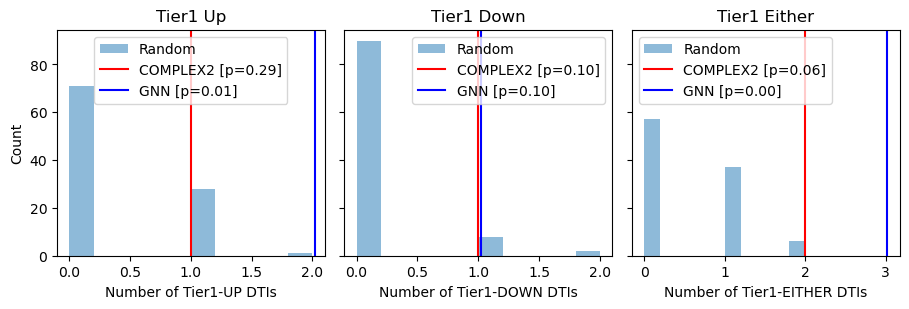

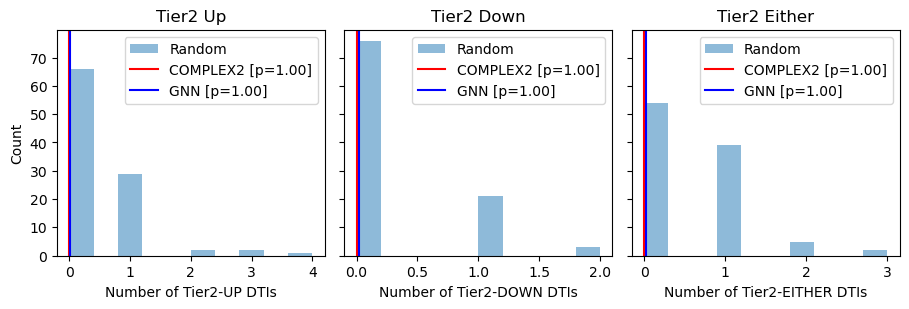

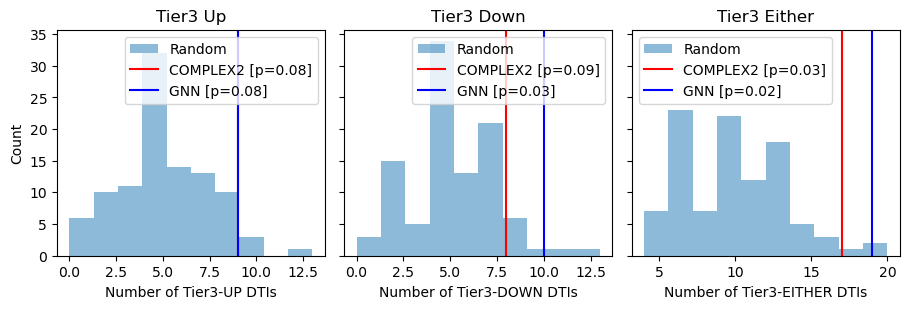

In [47]:
_bins = 10

for tier in ['Tier1', 'Tier2', 'Tier3']: 
    f,axes = plt.subplots(1,3, figsize=(9,3), sharey=True)
    axes[0].hist(cnts['rand'][tier]['up'], bins=_bins, alpha=0.5, label='Random')
    axes[1].hist(cnts['rand'][tier]['down'], bins=_bins, alpha=0.5, label='Random')
    axes[2].hist(cnts['rand'][tier]['either'], bins=_bins, alpha=0.5, label='Random')
    axes[0].axvline(cnts['cpx'][tier]['up'][0], color='red', label=f'COMPLEX2 [p={cnts_prob[(cnts_prob.tier == tier) & (cnts_prob.model == "cpx") & (cnts_prob.direction == "up")].pval.values[0]:.2f}]')
    axes[1].axvline(cnts['cpx'][tier]['down'][0], color='red', label=f'COMPLEX2 [p={cnts_prob[(cnts_prob.tier == tier) & (cnts_prob.model == "cpx") & (cnts_prob.direction == "down")].pval.values[0]:.2f}]')
    axes[2].axvline(cnts['cpx'][tier]['either'][0], color='red', label=f'COMPLEX2 [p={cnts_prob[(cnts_prob.tier == tier) & (cnts_prob.model == "cpx") & (cnts_prob.direction == "either")].pval.values[0]:.2f}]')
    axes[0].axvline(cnts['gnn'][tier]['up'][0]+0.02, color='blue', label=f'GNN [p={cnts_prob[(cnts_prob.tier == tier) & (cnts_prob.model == "gnn") & (cnts_prob.direction == "up")].pval.values[0]:.2f}]')
    axes[1].axvline(cnts['gnn'][tier]['down'][0]+0.02, color='blue', label=f'GNN [p={cnts_prob[(cnts_prob.tier == tier) & (cnts_prob.model == "gnn") & (cnts_prob.direction == "down")].pval.values[0]:.2f}]')
    axes[2].axvline(cnts['gnn'][tier]['either'][0]+0.02, color='blue', label=f'GNN [p={cnts_prob[(cnts_prob.tier == tier) & (cnts_prob.model == "gnn") & (cnts_prob.direction == "either")].pval.values[0]:.2f}]')
    axes[0].set_title(f'{tier} Up')
    axes[1].set_title(f'{tier} Down')
    axes[2].set_title(f'{tier} Either')
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    plt.tight_layout()
    
    axes[0].set_ylabel('Count')
    axes[0].set_xlabel(f'Number of {tier}-UP DTIs')
    axes[1].set_xlabel(f'Number of {tier}-DOWN DTIs')
    axes[2].set_xlabel(f'Number of {tier}-EITHER DTIs')
    plt.show()

    


In [107]:
n_tier1_gnn = [] ; n_tier2_gnn = [] ; n_tier3_gnn = []
n_tier1_cpx = [] ; n_tier2_cpx = [] ; n_tier3_cpx = []

xx = np.linspace(25, 2500, 25, dtype=int) 
n_rand = 50

for i in xx: 
    tmp1 = res[lambda x: (x.inhibitor == 'Venetoclax') & (x.gnn_drug_rank < i)]
    tmp2 = res[lambda x: (x.inhibitor == 'Venetoclax') & (x.cpx_drug_rank < i)]
    n_tier1_gnn.append( tmp1[lambda x: x.tiers.isin(['Tier1'])].shape[0] ) 
    n_tier1_cpx.append( tmp2[lambda x: x.tiers.isin(['Tier1'])].shape[0] )
    n_tier2_gnn.append( tmp1[lambda x: x.tiers.isin(['Tier2'])].shape[0] )
    n_tier2_cpx.append( tmp2[lambda x: x.tiers.isin(['Tier2'])].shape[0] )
    n_tier3_gnn.append( tmp1[lambda x: x.tiers.isin(['Tier3'])].shape[0] )
    n_tier3_cpx.append( tmp2[lambda x: x.tiers.isin(['Tier3'])].shape[0] )

n_tier1_rand_lcb = [] ; n_tier2_rand_lcb = [] ; n_tier3_rand_lcb = []
n_tier1_rand_ucb = [] ; n_tier2_rand_ucb = [] ; n_tier3_rand_ucb = []

for i in xx: 
    ntier1 = [] ; ntier2 = [] ; ntier3 = []
    for j in range(n_rand): 
        tmp = res[lambda x: (x.inhibitor == 'Venetoclax')].reset_index().sample(i, replace=False)
        ntier1.append( tmp[lambda x: x.tiers.isin(['Tier1'])].shape[0] )
        ntier2.append( tmp[lambda x: x.tiers.isin(['Tier2'])].shape[0] )
        ntier3.append( tmp[lambda x: x.tiers.isin(['Tier3'])].shape[0] )
    n_tier1_rand_lcb.append( np.percentile(ntier1, 2.5) )
    n_tier1_rand_ucb.append( np.percentile(ntier1, 97.5) )
    n_tier2_rand_lcb.append( np.percentile(ntier2, 2.5) )
    n_tier2_rand_ucb.append( np.percentile(ntier2, 97.5) )
    n_tier3_rand_lcb.append( np.percentile(ntier3, 2.5) )
    n_tier3_rand_ucb.append( np.percentile(ntier3, 97.5) )


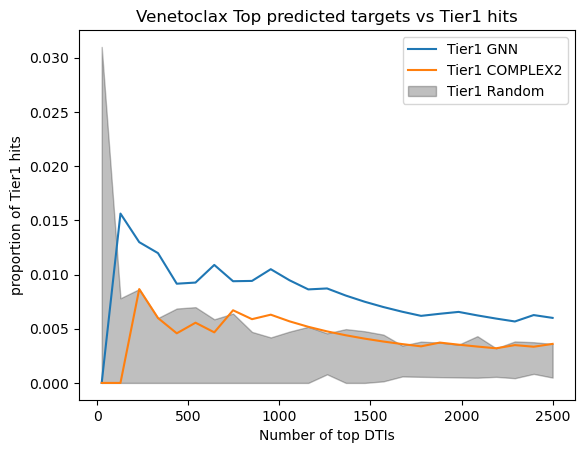

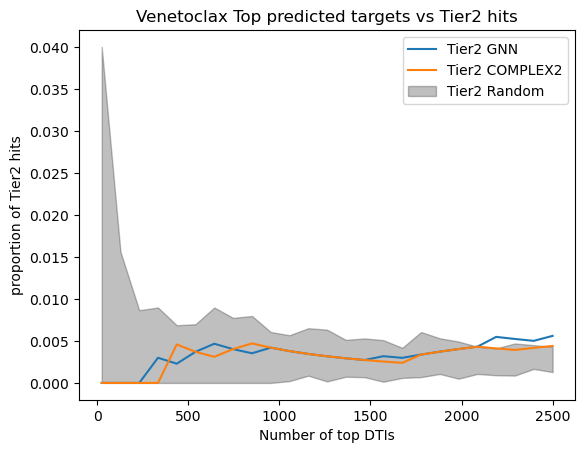

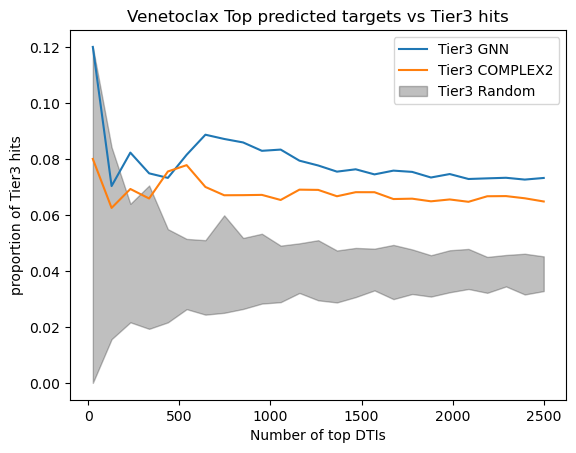

In [108]:
plt.figure() 
plt.plot(xx, np.array(n_tier1_gnn)/xx, label='Tier1 GNN')
plt.plot(xx, np.array(n_tier1_cpx)/xx, label='Tier1 COMPLEX2')
plt.fill_between(xx, n_tier1_rand_lcb/xx, n_tier1_rand_ucb/xx, alpha=0.25, color='k', label='Tier1 Random')
plt.legend()
plt.xlabel('Number of top DTIs')
plt.ylabel('proportion of Tier1 hits')
plt.title('Venetoclax Top predicted targets vs Tier1 hits')
plt.show()

plt.figure() 
plt.plot(xx, np.array(n_tier2_gnn)/xx, label='Tier2 GNN')
plt.plot(xx, np.array(n_tier2_cpx)/xx, label='Tier2 COMPLEX2')
plt.fill_between(xx, n_tier2_rand_lcb/xx, n_tier2_rand_ucb/xx, alpha=0.25, color='k', label='Tier2 Random')
plt.legend()
plt.xlabel('Number of top DTIs')
plt.ylabel('proportion of Tier2 hits')
plt.title('Venetoclax Top predicted targets vs Tier2 hits')
plt.show()

plt.figure() 
plt.plot(xx, np.array(n_tier3_gnn)/xx, label='Tier3 GNN')
plt.plot(xx, np.array(n_tier3_cpx)/xx, label='Tier3 COMPLEX2')
plt.fill_between(xx, n_tier3_rand_lcb/xx, n_tier3_rand_ucb/xx, alpha=0.25, color='k', label='Tier3 Random')
plt.legend()
plt.xlabel('Number of top DTIs')
plt.ylabel('proportion of Tier3 hits')
plt.title('Venetoclax Top predicted targets vs Tier3 hits')
plt.show()



# Top targets enriched for certain pathways

In [115]:
top100_gnn_ven_targs = res[lambda x: x.inhibitor == 'Venetoclax'].sort_values(by='gnn_drug_rank', ascending=True).head(100).target.unique()
top100_cpx_ven_targs = res[lambda x: x.inhibitor == 'Venetoclax'].sort_values(by='cpx_drug_rank', ascending=True).head(100).target.unique()

In [116]:
_ = [print(x) for x in top100_gnn_ven_targs]

BAX
BAK1
KCNH2
BBC3
CYCS
BAD
PIM3
BCL2L11
CHEK2
MAP2K5
CDK6
DDR1
BLK
RAF1
AURKA
STK10
PIM2
FLT3
NR4A3
ERN1
CDK1
ABL2
RET
HCK
BID
SLK
AAK1
PKMYT1
FRK
BMP2K
PTK6
ORAI1
DDR2
FGR
PLK3
PRKG1
NTRK3
PRKCE
MKNK1
PAK5
TYK2
BMX
MAPKAPK2
FLT1
BCAP31
DDX3X
PLK4
CDK5R1
MAP4K5
PDGFRA
LYN
DCLK1
TNK1
PDGFRB
TNNI3K
ERBB4
DCLK3
TNIK
CSF1R
PIM1
ABL1
KIT
IKBKE
JAK3
ABCG2
HIPK4
AXL
NUAK2
MINK1
BCL2A1
GAK
MKNK2
KDR
CDKL2
MAP4K4
FLT4
CLK2
HIPK1
STK16
BMPR2
MYT1
PRKD1
ERBB2
PRKACG
LRRK2
NTRK2
COQ9
GRK7
YES1
TAOK2
LTK
MELK
EPHB6
LCK
NPM1
TGFBR2
NTRK1
TIE1
CLK4
STEAP3


In [118]:
_ = [print(x) for x in top100_cpx_ven_targs]

BCL2L
BCLX
KIAA0271
BCLW
BAX
PRKCQ
BCL2L3
BAK1
BBC3
BID
MCL1
BRAF
EGFR
RAFB1
BCL2L11
BAD
ERBB2
PDGFRA
MAPK8
MAP2K5
LYN
TGFBR2
ROCK1
MTOR
CSF2
CDK1
IKBKB
MAPK1
NFE2L2
PRKACA
PAK6
SRC
NTRK2
CHUK
CIT
KIT
CSNK1A1
CSNK1E
PPP1CC
HSPA8
NFKBIA
AXL
AKT1
MYH10
CDKN1
BRAF1
MAPK7
PIK3C2B
RPS6KA3
CSNK2A1
GRK1
RAF1
PLK4
EIF2AK4
TAB1
MEK5
PPP5C
CDK19
DAPK1
IRAK1
HIPK2
TNF
STK3
RPS6KB1
BCL2L5
PIK3R1
JAK3
CAMKA
MYLK
VDAC2
ULK1
HIPK4
RIOK2
GNAI2
MTHFD2
MET
HBPA1
HDAC11
BMPR1B
CAMK
BCR
SHH
NOTCH1
IGFBP3
MAPK9
TIE1
KIAA0968
CREBBP
PDPK1
PIP4K2B
MAP2K1
CDK6
GSK3B
CYCS
IKKB
FGFR1
GABRA1
SPRY2
NEK9
BNIP3
